# Lab 2 assignment on recommender systems
We start by importing the necessary libraries.

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

## Data loading
Fill in the path to the data into the "train_file_path" and "test_file_path".

In [2]:
#Load the data from the files
train_file_path = r'lab2_train.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')

test_file_path = r'lab2_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=",")


## Data visualization
We chose to start by analyzing the distributions of likes and dislikes: 

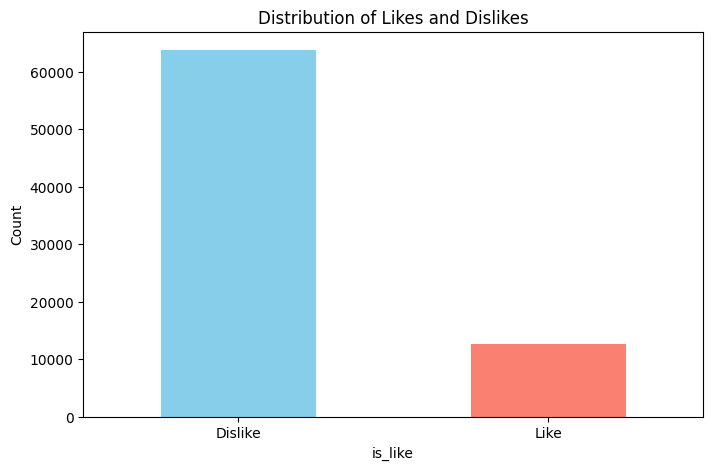

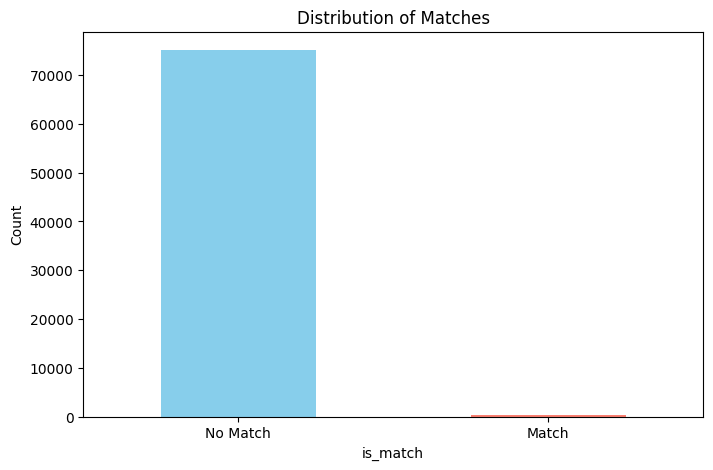

In [3]:
    # Visualize the distribution of likes and dislikes
    plt.figure(figsize=(8, 5))
    train_data['is_like'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribution of Likes and Dislikes')
    plt.xlabel('is_like')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Dislike', 'Like'], rotation=0)
    plt.show()
    
    # Visualize the distribution of matches
    plt.figure(figsize=(8, 5))
    train_data['is_match'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribution of Matches')
    plt.xlabel('is_match')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['No Match', 'Match'], rotation=0)
    plt.show()


Next we chose to visualize the data as a scatterplot of non-zero values.

In [ ]:
scatter_matrix = coo_matrix((train_data['is_like'].astype(int), (train_data['user_from_id'], train_data['user_to_id'])))
rows, columns = scatter_matrix.nonzero()

colors = scatter_matrix.tocsr()[rows, columns].A1

plt.scatter(columns, rows, c=colors, cmap = 'coolwarm', marker='s', s=0.1)
plt.colorbar(label="Likes")
plt.xlabel('Users liking')
plt.ylabel('Users being liked')
plt.title('Scatter matrix')
plt.show()


## Data preprocessing for NMF
### Dropping the matches column and removing any duplicates
Since the last column is incomplete, and the match rate is incredibly low, we decided to drop the matches column from the data, as it does not provide useful insights, and as per the assignment description we decided to only deal with likes and dislikes. 
We have also decided to remove any duplicate entries - a user that liked another users profile but then disliked it, or liked it twice - as they are outliers and difficult to deal with, and as such also do not provide much useful insight into the data.

In [5]:
# Drop the last column
train_data = train_data.iloc[:, :-1]
# Drop the duplicate entries where the user liking and the profile being evaluated are the same.
train_data = train_data.drop_duplicates(subset=['user_from_id', 'user_to_id'], keep=False)

### Removing users with too high like/dislike rates
In order for the data to be meaningful, we also chose to remove the entries from the users that had a like or dislike rate of over 90%, as it is not useful for recommendation to take that kind of data into account. 

In [6]:
# Calculate the percentage of likes and dislikes for each user
train_data['like_percentage'] = train_data.groupby('user_from_id')['is_like'].transform(lambda x: (x.sum() / len(x)) * 100)
train_data['dislike_percentage'] = 100 - train_data['like_percentage']

# Remove users with more than 95% likes or dislikes
train_data = train_data[(train_data['like_percentage'] <= 95) & (train_data['dislike_percentage'] <= 95)]

## Our NMF code
Following is our implementation of the non-negative matrix factorization algorithm.

In [7]:
def nmf(X: pd.DataFrame, n_components: int, max_iter: int, tol: float):

  #we used pseudocode from slides 72 and 75 of the "Dimensionality Reduction and Matrix Factorization lecture"
  #initial step - make sure X is a np.array for numerical functions
  X = np.array(X)
  #STEP 1 - Initialize W and H with random non-negative values
  W = np.random.rand(X.shape[0], n_components)
  H = np.random.rand(n_components, X.shape[1])

  #STEP 2 - repeat for the maximum number of iterations or until the error is small enough
  for i in range(max_iter):
      #STEP 2.1 - update W according to the given formula
      W *= X @ H.T / (W @ H @ H.T + 1e-9)

      #STEP 2.2 - update H according to the given formula
      H *= W.T @ X / (W.T @ W @ H + 1e-9)

      #STEP 2.3 - calculate error using Frobenius norm
      reconstructed_matrix = (X - W @ H)
      error = np.linalg.norm(reconstructed_matrix, 'fro')

      #STEP 2.4 - check if the error is small enough
      if error < tol:
          break

  return W, H

## Applying NMF for collaborative filtering:

First, we must convert the data into a data matrix.

In [17]:
# Create a data matrix for collaborative filtering
filtering_matrix = train_data.pivot(index='user_from_id', columns='user_to_id', values='is_like').fillna(False)
filtering_matrix = user_item_matrix.astype(int)

Then, we pick the parameters, choosing the number of components as 2, setting the maximum number of iterations at 300, and setting the threshold at 1e-3, which was informed by our initial results. We believe these parameters to be reasonable. 

In [ ]:
# Apply NMF to the matrix
n_components = 2
max_iter = 300
tol = 1e-3

W, H = nmf(filtering_matrix, n_components, max_iter, tol)

# W and H are the factorized matrices representing the users scrolling and the available profiles.
print("Matrix W (Users scrolling):")
print(W)
print("Matrix H (Available profiles):")
print(H)

## Our MinHash code
Following is our implementation of the min hashing function.

In [9]:
#This class was taken directly from the provided library in the weblab part of the assignment - we did not create this.
class HashFunction:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    def hashf(self, x, n):
        hash_value = 0
        hash_value =  (self.alpha * x + self.beta) % n
        return hash_value

In [10]:
def compute_minhash_signature_matrix(hashes: list[HashFunction], ids: list[set[int]]):
    
    # Initialize siganture matrix as (number of hash functions x number of id sets) matrix of "infinity"
    result = np.full((len(hashes), len(ids)), sys.maxsize)
    space = set().union(*ids)
    sorted_space = sorted(space)

    # Compute input matrix
    # First initialize it as (number of unique ids x number of id sets) matrix of 0s
    inputMatrix = np.full((len(space), len(ids)), 0)
    for column, idSet in enumerate(ids):
        for row, element in enumerate(sorted_space):
            # If the set contains the id, set the corresponding field to 1
            if element in idSet:
                inputMatrix[row, column] = 1

    # For each row in the input matrix
    for inputRowIndex, inputRow in enumerate(inputMatrix):
        # Fist calculate the hash values for the row number
        hashValues = [hashFunc.hashf(inputRowIndex, len(space)) for hashFunc in hashes]

        # Then find each index in the current row that is 1
        for inputColumnIndex, inputColumn in enumerate(inputRow):
            if (inputColumn == 1):
                # At such an index, check for each hash value whether the new hash value is smaller than the old one
                for hashFunctionIndex, hashValue in enumerate(hashValues):
                    if (hashValue < result[hashFunctionIndex, inputColumnIndex]):
                        # If it is replace the old with the new hash
                        result[hashFunctionIndex, inputColumnIndex] = hashValue
    
    return result